# Detección de "outliers" con el método de Tukey

En la lección anterior vimos cómo detectar "outliers" usando inspección visual. Y allí vimos que estos métodos, a pesar de ser simples, tienen la desventaja de que resultan siendo muy subjetivos y no son lo suficientemente precisos al momento de detectar valores extremos en la Serie de Tiempo.

En esta lección veremos el método de Tukey para la detección de valores extremos en Series de Tiempo, un método estadístico que permite realizar una detección más rigurosa en comparación con los métodos de inspección visual.

Comenzaremos retomando lo visto en la lección anterior con respecto al método de detección de "outliers" usando *boxplots* y partiendo de esto veremos todos los detalles del método de Tukey.

Al final, resumiremos las características del método y las situaciones en las que resulta aconsejable usarlo.

## 1. Repaso: detección de "outliers" usando *boxplots*

En la lección anterior vimos que este método consiste en:

1. Generar un *boxplot* de las observaciones de la Serie de Tiempo
2. A partir del *boxplot* se estiman de manera aproximada los límites superior e inferior (*whiskers*) y luego se usan estos valores para filtrar la Serie de Tiempo y extraer de esta forma los valores extremos

![](boxplots-deteccion-outliers.png)

Pues en esencia el método de Tukey hace esto mismo pero de forma mucho más precisa: en lugar de estimar de forma aproximada los límites superior e inferior lo que hace es calcularlos de forma exacta a partir de los datos.

Veamos en detalle este método:

## 2. El método de Tukey para la detección de "outliers"

Este método se puede resumir en 4 sencillos pasos:

1. Calcular los cuartiles 1 y 3 (Q1, Q3) a partir de las observaciones de la Serie de Tiempo
2. Calcular el rango intercuartiles como: $IQR = Q_3 - Q_1$
3. Calcular los límites superior e inferior (*whiskers*):
    - Límite inferior: $l_{inf} = Q_1 - 1.5IQR$
    - Límite superior: $l_{sup} = Q_3 + 1.5IQR$
4. Los "outliers" serán las observaciones dentro de la Serie por encima del límite superior ($l_{sup}$) y por debajo del límite inferior ($l_{inf}$)

Así que veamos de forma práctica cómo implementar este método.

## 3. Función auxiliar

Usaremos la misma función `graficar_outliers` de la lección anterior:

In [ ]:
# Graficar outliers
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_outliers(serie, fechas, outliers=None):
    '''Graficar la Serie de Tiempo y superponer "outliers" de
    referencia y detectados.
    
    Parámetros:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    - fechas: listado de fechas con los "outliers" conocidos
    - outliers: los outliers detectados (DataFrame de Pandas)'''
    
    # Graficar la Serie de tiempo
    ax = serie.plot(alpha=0.7)
    
    # Superponer outliers de referencia
    serie.loc[fechas].plot(ax=ax, style='bo')
    
    # Superponer outliers detectados (si existen)
    if outliers is not None:
        outliers.plot(ax=ax, style='rx')
        plt.legend(['Serie de Tiempo', 'Outliers conocidos', 'Outliers detectados']);
    else:
        plt.legend(['Serie de Tiempo', 'Outliers conocidos'])
    
    # Ajustar etiquetas    
    plt.xlabel('Fecha')
    plt.ylabel('# pasajeros')    

Hagamos una prueba de esta función con un dataset sintético:

            valores
2024-01-01       23
2024-01-02       17
2024-01-03        6
2024-01-04       15
2024-01-05       80
2024-01-06       12
2024-01-07       19
2024-01-08       21


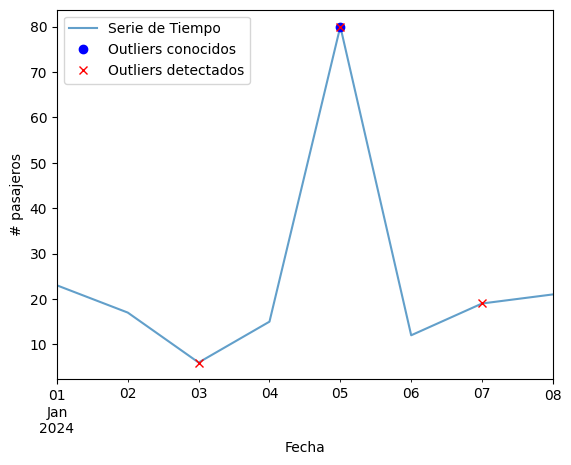

In [2]:
import pandas as pd

# Crear Serie de Tiempo
inds = pd.date_range(pd.to_datetime("2024-01-01"), pd.to_datetime("2024-01-08"))
obs = [23, 17, 6, 15, 80, 12, 19, 21]
df = pd.DataFrame(obs, index=inds, columns=["valores"])
print(df)

# Fechas con outliers conocidos
fechas = ['2024-01-05']

# Simular outliers detectados
outliers = df.iloc[[2,4,6],:]

graficar_outliers(df, fechas, outliers)

Y ahora preparemos el set de datos

## 3. El set de datos

Usaremos el mismo set de datos de la lección anterior (*taxis_ny.csv*) que contiene el número de pasajeros que han hecho uso del servicio de Taxis de la ciudad de Nueva York entre el 1 de julio de 2014 y el 31 de mayo de 2015.

Los datos han sido tomados con frecuencia de 30 minutos y en total se tienen 10.320 registros:

In [3]:
# Lectura del set de datos

RUTA = '../datasets/outliers/'

taxis_df = pd.read_csv(RUTA + 'taxis_ny.csv',
                    parse_dates = ['tiempo'],
                    index_col = ['tiempo'])
taxis_df

,obs
tiempo,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


Y creemos el listado con "outliers" conocidos:

In [4]:
# fechas con outliers conocidos
fechas =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

Como lo vimos en la lección anterior, la detección de valores extremos funciona mejor cuando remuestreamos la Serie a una frecuencia diaria:

In [5]:
# Remuestreo a frecuencia diaria
tx_diaria = taxis_df.resample('D').mean()
tx_diaria

,obs
tiempo,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


Y generemos el gráfico correspondiente (la Serie remuestreada y los valores extremos conocidos):

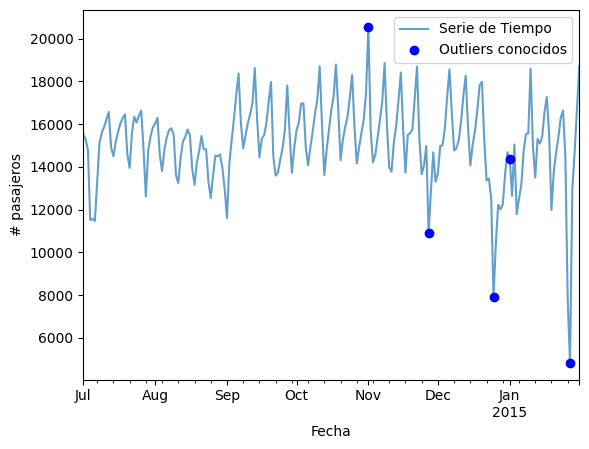

In [6]:
graficar_outliers(tx_diaria, fechas)

Perfecto, este es nuestro punto de partida. Ahora sí implementemos el método de Tukey.

## 4. Implementación del método de Tukey

A continuación implementaremos una sencilla función (`outliers_tukey`) que permite realizar esta detección usando el método descrito anteriormente:

In [7]:
import numpy as np

def outliers_tukey(serie):
    '''Detecta los "outliers" en la Serie de Tiempo usando
    el método de Tukey.
    
    Entradas:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    
    Salida:
    - outliers: DataFrame de Pandas con los valores extremos detectados
    '''
    
    # 1. Calcular Q1 y Q3
    q1, q3 = np.percentile(serie, [25, 75])
    
    # 2. Calcular IQR
    IQR = q3 - q1
    
    # 3. Calcular límites superior e inferior
    lim_sup = q3 + 1.5*IQR
    lim_inf = q1 - 1.5*IQR
    
    # 4. Filtrar serie de tiempo para detectar los outliers
    outliers = serie[(serie.to_numpy() > lim_sup) | (serie.to_numpy() < lim_inf)]
    
    return outliers

¡Y listo, con esta sencilla función ya hemos implementado el método de Tukey!

Pongámoslo a prueba con nuestra Serie de Tiempo remuestreada:

In [8]:
outliers = outliers_tukey(tx_diaria)
outliers

,obs
tiempo,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


Y ahora grafiquemos la Serie de Tiempo, los "outliers" conocidos y los que acabamos de detectar:

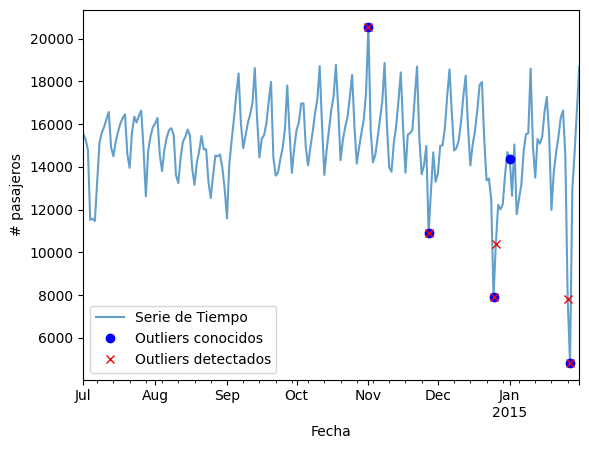

In [9]:
graficar_outliers(tx_diaria, fechas, outliers)

Y vemos que funciona bastante bien pues hemos detectado 4 de los 5 "outliers" de referencia. Aunque hay que tener en cuenta que en realidad el "outlier" del 1 de enero de 2015 no se podría haber detectado ni siquiera usando el método de inspección visual.

## 5. Aspectos a tener en cuenta

Bien, acabamos de ver que el método de Tukey funciona de manera muy similar a la detección de "outliers" con inspección visual usando *boxplots*. Sin embargo la ventaja del método de Tukey es que es más preciso, pues los límites superior e inferior se calculan directamente a partir de los gráficos.

Además, como el método de Tukey se basa en el uso de percentiles y del rango intercuartiles, cabe resaltar que es un método que funciona cuando la distribución de las observaciones no necesariamente sigue una distribución Normal o Gaussiana.

Por ejemplo, si dibujamos la distribución de nuestra Serie de Tiempo (remuestreada) veremos que no es exactamente Gaussiana:

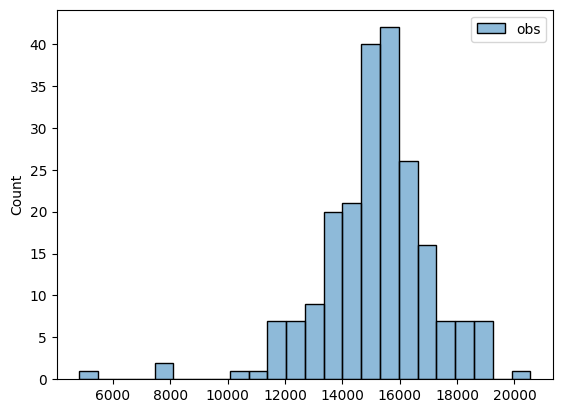

In [10]:
sns.histplot(tx_diaria);

Así que se trata de un método robusto de detección de "outliers" que funciona con datos con o sin distribución Gaussiana.